# Exploratory Data Analysis (EDA) for Beijing pm2.5 datasets

reference: https://www.kaggle.com/stephaniestallworth/housing-feature-engineering-regression  
http://scikit-learn.org/stable/modules/feature_selection.html#feature-selection

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [10, 5]
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib
from util import *
#resize the inline figure
matplotlib.rcParams['figure.figsize'] = [12, 9]

In [23]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
#         names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        names += [(var_name + '(t-%d)' % (i)) for j, var_name in enumerate(df.columns.values)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [var_name + '(t)' for j, var_name in enumerate(df.columns.values)]
        else:
            names += [(var_name + '(t+%d)' % (i)) for j, var_name in enumerate(df.columns.values)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [24]:
raw_data = pd.read_csv("raw_data_new.csv", parse_dates=[0], index_col=0)
raw_data.head()

,pm25,t2m,d2m,u10,v10,sp,t500,t850,t1000,q500,...,q1000,u500,u850,u1000,v500,v850,v1000,w500,w850,w1000
2014-01-01 08:00:00,51.0,270.487368,258.980250,2.507680,-0.658156,97997.728951,248.554676,270.020533,276.617789,0.000131,...,0.001265,23.046411,10.548611,3.180156,-20.240968,-9.274819,-0.819754,-0.362159,0.270265,0.257394
2014-01-01 14:00:00,23.0,283.838611,258.241520,3.154037,-0.050984,98048.881796,249.264215,270.571515,282.831868,0.000194,...,0.001557,23.175371,8.060430,3.081539,-16.076533,-5.246438,0.187835,-0.213867,0.326162,0.170515
2014-01-01 20:00:00,66.0,273.009328,261.723400,1.842218,-1.248453,98354.616140,248.722481,271.406578,282.505506,0.000195,...,0.001777,23.576161,6.588762,1.987903,-10.424377,-6.522191,-1.084960,-0.113473,0.107447,0.193131
2014-01-02 02:00:00,127.0,270.101179,262.794066,0.369782,-1.550008,98568.984998,248.943138,271.072288,278.768867,0.000185,...,0.001637,18.130736,5.157552,0.032000,-7.689495,-0.974540,-2.949295,0.033899,-0.050130,0.173733
2014-01-02 08:00:00,119.0,268.554291,262.665035,0.382165,-1.082520,98565.141143,248.187354,271.501711,275.817080,0.000187,...,0.001611,17.444210,7.410570,0.221648,-2.653525,2.969054,-1.754386,0.091726,-0.135630,0.127581


In [25]:
df_corr = raw_data.corr()
df_corr['pm25'][1:].sort_values(ascending=False)

v850     0.295540
v1000    0.275126
v10      0.274630
v500     0.243625
u850     0.169844
d2m      0.050811
u500     0.028554
t850     0.021652
q1000    0.005843
q850     0.001537
sp      -0.005643
t500    -0.018446
w500    -0.064065
q500    -0.064419
u10     -0.067464
t1000   -0.068881
u1000   -0.079923
t2m     -0.100240
w850    -0.181376
w1000   -0.244126
Name: pm25, dtype: float64

In [26]:
data = series_to_supervised(raw_data, 8, 1)

In [27]:
# Compute correlation with pm25
data.corr()['pm25(t)'][1:].sort_values(ascending=False)

pm25(t)       1.000000
pm25(t-1)     0.759444
pm25(t-2)     0.589762
pm25(t-3)     0.497378
pm25(t-4)     0.408102
v1000(t-1)    0.365772
v850(t-1)     0.361890
v850(t-2)     0.359672
v10(t-1)      0.356738
v1000(t-2)    0.324668
v10(t-2)      0.313441
v850(t-3)     0.312848
v850(t)       0.295817
pm25(t-5)     0.292766
v1000(t)      0.275622
v10(t)        0.274993
v1000(t-3)    0.273136
v10(t-3)      0.267852
v1000(t-4)    0.257112
v10(t-4)      0.252946
v850(t-4)     0.251514
v500(t)       0.243441
v1000(t-5)    0.218864
pm25(t-6)     0.208158
v10(t-5)      0.207244
sp(t-8)       0.206948
u850(t-1)     0.204293
sp(t-7)       0.200742
u850(t-2)     0.194143
v850(t-5)     0.186571
                ...   
q850(t-7)    -0.132829
t850(t-8)    -0.137478
q500(t-4)    -0.138508
d2m(t-8)     -0.138658
q1000(t-8)   -0.139028
q850(t-8)    -0.140256
t500(t-7)    -0.142014
t1000(t-6)   -0.142691
t2m(t-4)     -0.143525
t2m(t-3)     -0.145464
t2m(t-6)     -0.146451
q500(t-5)    -0.148638
w850(t-3)  

## Data visualizing 

春:
78.16123680241326
72.14181938257205
夏:
62.4581884057971
48.33844557765257
秋：
82.11518807665011
82.71654524474926
冬：
98.26761904761906
113.49660590466232


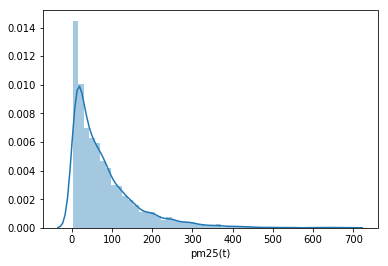

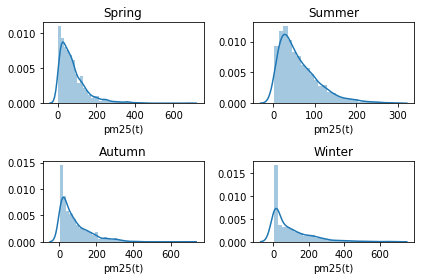

In [8]:
#pm2.5频率分布直方图，及四季频率分布直方图
pm25_data = data['pm25(t)']
time_index = pm25_data.index
sns.distplot(pm25_data)
plt.savefig('fig1.png')

f, axes = plt.subplots(2, 2)
spring_pm25 = pm25_data[(time_index.month == 3) | (time_index.month == 4) |  (time_index.month == 5)]
sns.distplot(spring_pm25, ax=axes[0,0])
axes[0,0].set_title('Spring')

summer_pm25 = pm25_data[(time_index.month == 6) | (time_index.month == 7) |  (time_index.month == 8)]
sns.distplot(summer_pm25, ax=axes[0,1])
axes[0,1].set_title('Summer')

autumn_pm25 = pm25_data[(time_index.month == 9) | (time_index.month == 10) |  (time_index.month == 11)]
sns.distplot(autumn_pm25, ax=axes[1,0])
axes[1,0].set_title('Autumn')

winter_pm25 = pm25_data[(time_index.month == 12) | (time_index.month == 1) |  (time_index.month == 2)]
sns.distplot(winter_pm25, ax=axes[1,1])
axes[1,1].set_title('Winter')

plt.tight_layout()
plt.savefig('fig2.png')

#平均值
print("春:")
print(spring_pm25.mean())
print(spring_pm25.std())
print("夏:")
print(summer_pm25.mean())
print(summer_pm25.std())
print("秋：")
print(autumn_pm25.mean())
print(autumn_pm25.std())
print("冬：")
print(winter_pm25.mean())
print(winter_pm25.std())

83.50365938839656
93.52042978507697
82.64870687512978
68.89334808004844


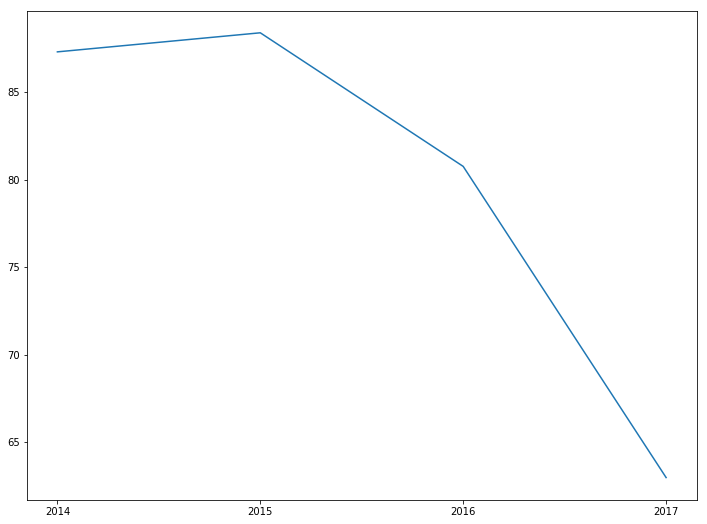

In [21]:
l = []
year_list = ['2014', '2015', '2016', '2017']
for year in year_list:
    l.append(pm25_data.loc[year].mean())
    print(pm25_data.loc[year].std())

plt.plot(year_list, l)
plt.savefig("year.png")

In [75]:
#计算空气质量等级
def air_quality_rank(x):
    """
    根据国标，计算一级到六级空气质量
    """
    if x <= 50:
        return 1
    elif x <= 100:
        return 2
    elif x <= 150:
        return 3
    elif x <= 200:
        return 4
    elif x <= 300:
        return 5
    else:
        return 6

# pm25_data['rank'] = pm25_data.apply(air_quality_rank)
pm25_data = pd.concat((pm25_data, pm25_data.apply(air_quality_rank)), axis = 1)

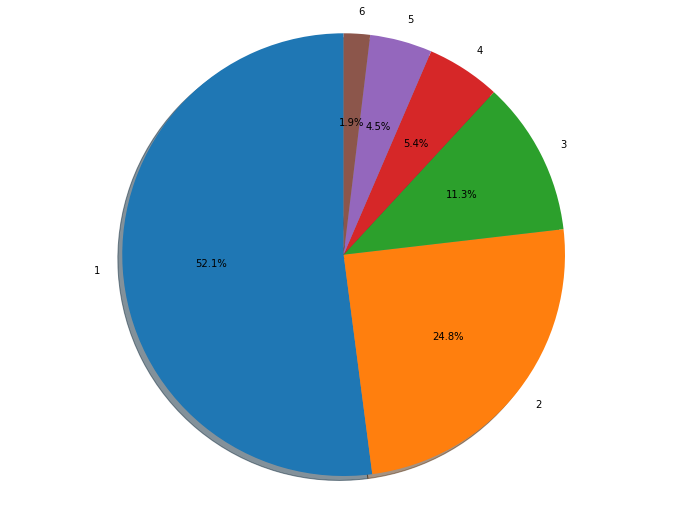

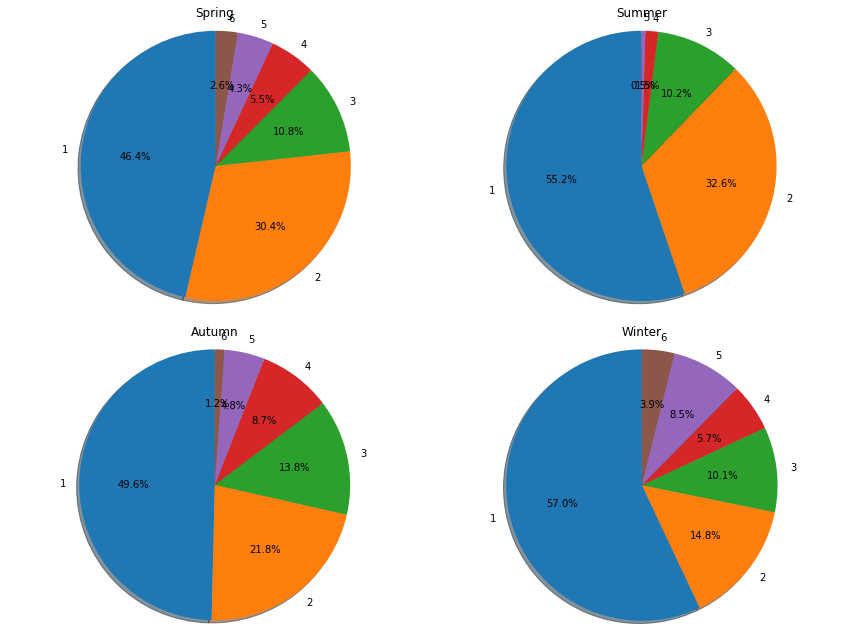

In [77]:
#画出空气质量等级饼图，及四季饼图
pm25_data.columns = ('pm25', 'rank')
counts_data = pm25_data.groupby('rank').size().reset_index(name='counts')
counts = counts_data['counts']

fig1, ax1 = plt.subplots()
ax1.pie(counts, labels=[1,2,3,4,5,6], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.savefig('fig3.png')

def calculate_counts(input_data):
    """
    Calculate the rank counts of pm25 data
    """
    df = pd.concat((input_data, input_data.apply(air_quality_rank)), axis = 1)
    df.columns = ('pm25', 'rank')
    counts_data = df.groupby('rank').size().reset_index(name='counts')
    return counts_data['counts']
    

fig2, axes = plt.subplots(2, 2)
axes[0, 0].pie(calculate_counts(spring_pm25), labels=[1,2,3,4,5,6], autopct='%1.1f%%',
        shadow=True, startangle=90)
axes[0, 0].axis('equal') 
axes[0, 0].set_title('Spring')

axes[0, 1].pie(calculate_counts(summer_pm25), labels=[1,2,3,4,5], autopct='%1.1f%%',
        shadow=True, startangle=90)
axes[0, 1].axis('equal') 
axes[0, 1].set_title('Summer')

axes[1, 0].pie(calculate_counts(autumn_pm25), labels=[1,2,3,4,5,6], autopct='%1.1f%%',
        shadow=True, startangle=90)
axes[1, 0].axis('equal') 
axes[1, 0].set_title('Autumn')

axes[1, 1].pie(calculate_counts(winter_pm25), labels=[1,2,3,4,5,6], autopct='%1.1f%%',
        shadow=True, startangle=90)
axes[1, 1].axis('equal') 
axes[1, 1].set_title('Winter')

plt.tight_layout()
plt.savefig('fig4.png')

# Feature Engineering
Select most important features affecting pm2.5 of Beijing

In [111]:
from sklearn.feature_selection import SelectPercentile, f_regression, mutual_info_regression

In [112]:
#(189: 21 * 8 + 21)
X = data.iloc[:, :21*8]
y = data.iloc[:, 21*8]

In [113]:
# Select top 20% features according to f_regression score. 根据f score选出最重要的20%因子 
#TODO: f_regression只能衡量变量间的线性关系，mutual_info_regression可以衡量非线性关系。可尝试mutual_info_regression
selector_f = SelectPercentile(mutual_info_regression, percentile=20)
x_best = selector_f.fit_transform(X, y)

In [114]:
support = selector_f.get_support()
# Column names of top 20%
features = np.asarray(X.columns.values)
features_with_support = features[support]

#f-scores of top 20%
fscores = np.asarray(selector_f.scores_)
fscores_with_support = fscores[support]

# p-values of top 20%
pvalues = np.asarray(selector_f.pvalues_)
pvalues_with_support = pvalues[support]

IndexError: too many indices for array

In [32]:
# Dataframe of top 20%
top20 = pd.DataFrame({'F-score':fscores_with_support,
                      'p-value':pvalues_with_support},
                     index = features_with_support)
# top20.index.name = 'Feature'
print('Top 20% best associated features to pm25\nNumber of features:',len(features_with_support))
print(top20.sort_values(by = 'p-value', ascending = 'True'))

Top 20% best associated features to pm25
Number of features: 34
                F-score        p-value
pm25(t-1)   7464.854901   0.000000e+00
pm25(t-2)   2921.508685   0.000000e+00
pm25(t-3)   1800.617044   0.000000e+00
pm25(t-4)   1094.657066  5.183868e-219
v1000(t-1)   846.097905  4.163873e-173
v850(t-1)    825.538848  3.143974e-169
v850(t-2)    813.952832  4.881293e-167
v10(t-1)     798.797247  3.637441e-164
w1000(t-1)   646.580165  6.365781e-135
v1000(t-2)   645.470779  1.046337e-134
v10(t-2)     596.824342  3.331130e-125
v850(t-3)    594.319541  1.032731e-124
w1000(t-2)   530.196648  4.618346e-112
pm25(t-5)    513.548858  9.362078e-109
v1000(t-3)   441.622907   2.331343e-94
v10(t-3)     423.394209   1.108430e-90
v1000(t-4)   387.766731   1.842952e-83
v10(t-4)     374.448546   9.472553e-81
v850(t-4)    369.937743   7.872430e-80
w1000(t-3)   347.350041   3.253481e-75
v1000(t-5)   275.605059   1.999027e-60
w1000(t-4)   275.404766   2.199775e-60
pm25(t-6)    248.110189   1.048329e-54


p-value 均小于0.05，故而这些feature都有统计显著性

## Feature to Feature Correlation
reduce redundancy, colinearity （分析变量间的相关关系，减少冗余信息，减少共线性）

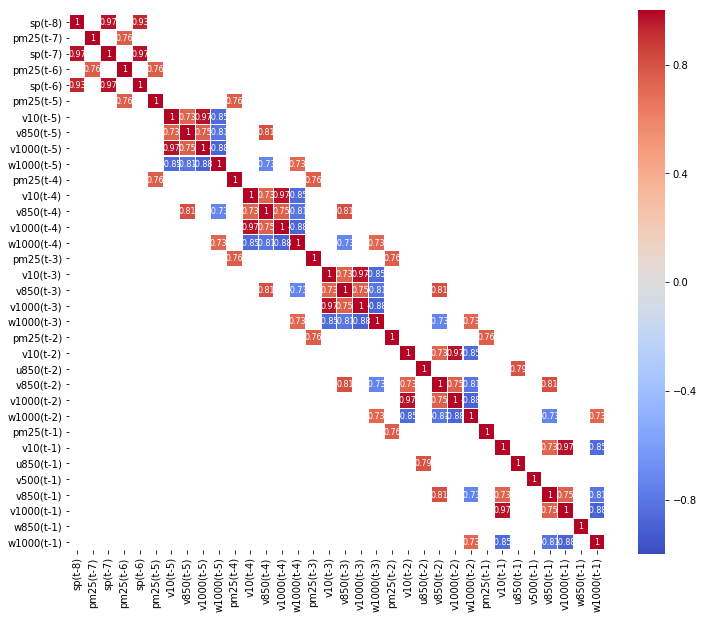

In [33]:

best_feat = data[features_with_support]
# 计算自变量间的相关系数
corr =best_feat.corr() 
plt.figure(figsize=(12, 10))

# 用heatmap画出大于0.7的相关系数
sns.heatmap(corr[(corr >= 0.7) | (corr <= -0.7)], 
            cmap='coolwarm', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

plt.savefig('correlation_1.png')

我们的目的是，对相关系数大于0.8的因子对，只保留其中一个因子。
如何舍弃呢？用下面的与pm2.5的相关系数大小衡量。与pm2.5相关性高的保留，否则去掉

In [34]:
# Correlation with pm25
pd.concat([data[features_with_support], data['pm25(t)']], axis=1).corr()['pm25(t)'][1:].sort_values(ascending=False)

pm25(t)       1.000000
pm25(t-1)     0.759444
pm25(t-2)     0.589762
pm25(t-3)     0.497378
pm25(t-4)     0.408102
v1000(t-1)    0.365772
v850(t-1)     0.361890
v850(t-2)     0.359672
v10(t-1)      0.356738
v1000(t-2)    0.324668
v10(t-2)      0.313441
v850(t-3)     0.312848
pm25(t-5)     0.292766
v1000(t-3)    0.273136
v10(t-3)      0.267852
v1000(t-4)    0.257112
v10(t-4)      0.252946
v850(t-4)     0.251514
v1000(t-5)    0.218864
pm25(t-6)     0.208158
v10(t-5)      0.207244
u850(t-1)     0.204293
sp(t-7)       0.200742
u850(t-2)     0.194143
v850(t-5)     0.186571
v500(t-1)     0.184076
sp(t-6)       0.181902
pm25(t-7)     0.176888
w1000(t-5)   -0.179189
w850(t-1)    -0.185113
w1000(t-4)   -0.218788
w1000(t-3)   -0.244187
w1000(t-2)   -0.297062
w1000(t-1)   -0.324917
Name: pm25(t), dtype: float64

In [35]:
# v10(t-5) vs v1000(t-5) vs w1000(t-5): 保留 v1000(t-5)
# sp(t-7) vs sp(t-8): drop sp(t-7)
# v850(t-4) vs v850(t-5): drop v850(t-5)
# v10(t-4) vs v1000(t-4) vs w1000(t-4):  保留v1000(t-4)
# v10(t-3) vs v1000(t-3) vs w1000(t-3): 保留v1000(t-3)
# v10(t-2) vs v1000(t-2) vs w1000(t-2): 保留v1000(t-2)
# v850(t-1) vs v850(t-2): drop v850(t-2)
# v850(t-1) vs v10(t-1) vs v1000(t-1): drop v10(t-1), v1000(t-1)
# v850(t-1) vs w1000(t-1): drop w1000(t-1)
# v850(t-3) vs v850(t-4): drop v850(t-4)
best_feat = best_feat.drop(['v10(t-5)', 'w1000(t-5)', 'sp(t-7)', 'v850(t-5)', 'v10(t-4)', 'w1000(t-4)',
                           'v10(t-3)', 'w1000(t-3)', 'v10(t-2)', 'w1000(t-2)', 'v850(t-2)', 'v10(t-1)', 'v1000(t-1)', 'w1000(t-1)', 'v850(t-4)'], axis=1)

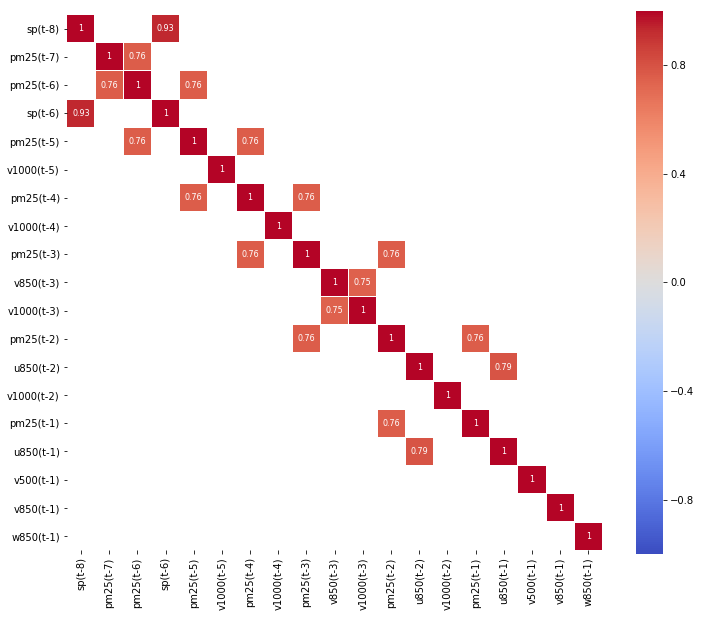

In [36]:
corr = best_feat.corr() # We already examined SalePrice correlations
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.7) | (corr <= -0.7)], 
            cmap='coolwarm', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);
plt.savefig('correlation_2.png')

In [37]:
# These are the most important features affecting pm2.5!
best_feat.columns

Index(['sp(t-8)', 'pm25(t-7)', 'pm25(t-6)', 'sp(t-6)', 'pm25(t-5)',
       'v1000(t-5)', 'pm25(t-4)', 'v1000(t-4)', 'pm25(t-3)', 'v850(t-3)',
       'v1000(t-3)', 'pm25(t-2)', 'u850(t-2)', 'v1000(t-2)', 'pm25(t-1)',
       'u850(t-1)', 'v500(t-1)', 'v850(t-1)', 'w850(t-1)'],
      dtype='object')

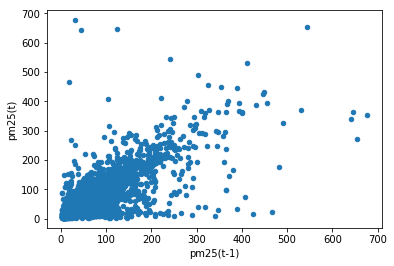

In [19]:
# 画出某个feature与pm2.5之间的散点图
var = 'pm25(t-1)'
data_combined = pd.concat([best_feat[var], data['pm25(t)']], axis=1)
data.plot.scatter(x=var, y='pm25(t)')
plt.savefig('scatter_1.png')

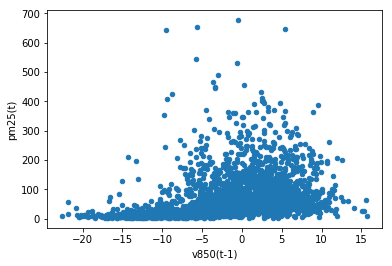

In [20]:
# 画出某个feature与pm2.5之间的散点图
var = 'v850(t-1)'
data_combined = pd.concat([best_feat[var], data['pm25(t)']], axis=1)
data.plot.scatter(x=var, y='pm25(t)')
plt.savefig('scatter_2.png')

# SVM

In [42]:
data_after_feature_selection = pd.concat([best_feat, data['pm25(t)']], axis=1)
data_after_feature_selection

,sp(t-8),pm25(t-7),pm25(t-6),sp(t-6),pm25(t-5),v1000(t-5),pm25(t-4),v1000(t-4),pm25(t-3),v850(t-3),v1000(t-3),pm25(t-2),u850(t-2),v1000(t-2),pm25(t-1),u850(t-1),v500(t-1),v850(t-1),w850(t-1),pm25(t)
2014-01-03 08:00:00,97997.728951,23.0,66.0,98354.616140,127.0,-2.949295,119.0,-1.754386,108.0,1.569078,0.806979,168.0,6.941507,-1.026792,122.0,2.872926,-3.809984,-11.719848,0.467191,30.0
2014-01-03 14:00:00,98048.881796,66.0,127.0,98568.984998,119.0,-1.754386,108.0,0.806979,168.0,-6.505430,-1.026792,122.0,2.872926,-4.760390,30.0,-4.042902,-8.480185,-10.603811,0.074810,16.0
2014-01-03 20:00:00,98354.616140,127.0,119.0,98565.141143,108.0,0.806979,168.0,-1.026792,122.0,-11.719848,-4.760390,30.0,-4.042902,-4.742644,16.0,0.350609,-9.105245,-4.878698,-0.017033,57.0
2014-01-04 02:00:00,98568.984998,119.0,108.0,98220.376883,168.0,-1.026792,122.0,-4.760390,30.0,-10.603811,-4.742644,16.0,0.350609,-1.426081,57.0,2.450644,-1.086932,-1.455658,-0.207799,76.0
2014-01-04 08:00:00,98565.141143,108.0,168.0,98300.802165,122.0,-4.760390,30.0,-4.742644,16.0,-4.878698,-1.426081,57.0,2.450644,3.129756,76.0,5.315592,-9.560730,1.473446,-0.213407,78.0
2014-01-04 14:00:00,98220.376883,168.0,122.0,98494.769021,30.0,-4.742644,16.0,-1.426081,57.0,-1.455658,3.129756,76.0,5.315592,2.293714,78.0,6.970586,-11.848014,5.569854,-0.306998,170.0
2014-01-04 20:00:00,98300.802165,122.0,30.0,98825.044903,16.0,-1.426081,57.0,3.129756,76.0,1.473446,2.293714,78.0,6.970586,2.492865,170.0,6.687379,-2.460289,3.182008,-0.132504,206.0
2014-01-05 02:00:00,98494.769021,30.0,16.0,98795.476785,57.0,3.129756,76.0,2.293714,78.0,5.569854,2.492865,170.0,6.687379,2.076816,206.0,6.608991,-9.384254,-3.245064,0.120134,151.0
2014-01-05 08:00:00,98825.044903,16.0,57.0,99022.559934,76.0,2.293714,78.0,2.492865,170.0,3.182008,2.076816,206.0,6.608991,1.010074,151.0,4.517806,-15.566824,-9.033274,0.367992,90.0
2014-01-05 14:00:00,98795.476785,57.0,76.0,99041.483529,78.0,2.492865,170.0,2.076816,206.0,-3.245064,1.010074,151.0,4.517806,-2.352826,90.0,0.160961,-15.946395,-9.190032,0.237444,29.0


In [61]:
# Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(data_after_feature_selection)

In [86]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

# Turn off shuffle, because it's a sequense model!!!
train, test = train_test_split(scaled, train_size=0.8, test_size=0.2, shuffle=False)

train_X = train[:, :-1]    
train_y = train[:, -1]
test_X = test[:, :-1]
test_y = test[:, -1]

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# train_X = train_X.reshape(train_X.shape[0], lag_hours, 21)
# test_X = test_X.reshape(test_X.shape[0], lag_hours, 21)

(4384, 19) (4384,) (1096, 19) (1096,)


In [124]:
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [0.001, 0.01, 0.05, 0.1, 0.2],
                     'C': [0.5, 1, 2, 4, 8, 16]},
                    {'kernel': ['linear'], 'C': [0.0001, 0.001, 0.1, 1, 2]}]


print("# Tuning hyper-parameters for SVM")
print()

clf = GridSearchCV(svm.SVR(kernel='rbf'), tuned_parameters[1], cv=5)
clf.fit(train_X, train_y)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
#     print(classification_report(y_true, y_pred))
#     print()

# Tuning hyper-parameters for SVM

Best parameters set found on development set:

{'C': 2, 'kernel': 'linear'}

Grid scores on development set:

0.072 (+/-0.028) for {'C': 0.0001, 'kernel': 'linear'}
0.298 (+/-0.030) for {'C': 0.001, 'kernel': 'linear'}
0.612 (+/-0.021) for {'C': 0.1, 'kernel': 'linear'}
0.615 (+/-0.024) for {'C': 1, 'kernel': 'linear'}
0.615 (+/-0.024) for {'C': 2, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



In [125]:
train_y

array([0.03958944, 0.01906158, 0.07917889, ..., 0.01612903, 0.01759531,
       0.01026393])

(4384,)
predict_hours 0
mae:
36.47239981483582
rmse:
54.16327546528808
mape:
0.7191123060037665


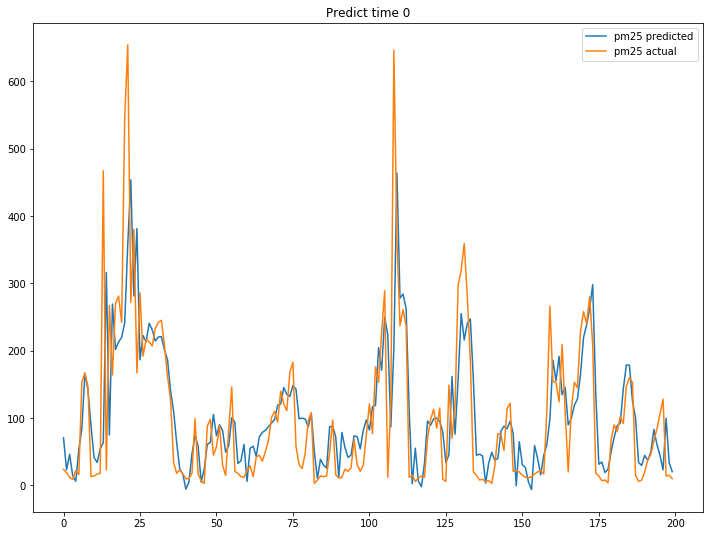

In [126]:
predict_hours = 1
y_train_svm = clf.predict(train_X)

pm25_train_svm = scaler.inverse_transform(np.tile(y_train_svm.reshape(-1, 1), 20))[:, -1]
train_y_true = scaler.inverse_transform(np.tile(train_y.reshape(-1, 1), 20))[:, -1]
# pm25_train_svm = y_train_svm
# train_y_true = train_y
print(train_y.shape)

for i in range(predict_hours):
    print("predict_hours " + str(i))
    print("mae:")
    print(mean_absolute_error(pm25_train_svm[:], train_y_true[:]))
    print("rmse:")
    print(math.sqrt(mean_squared_error(pm25_train_svm[:], train_y_true[:])))
    print("mape:")
    print(mean_absolute_percentage_error(pm25_train_svm[:], train_y_true[:]))
 
# Plot for linear regression
for i in range(predict_hours):
    plt.subplot(predict_hours, 1, i+1)
    plt.plot(pm25_train_svm[-200:], '-', label = 'pm25 predicted')
    plt.plot(train_y_true[-200:], '-', label = 'pm25 actual')
    plt.legend()
    plt.title('Predict time '+ str(i))
    plt.show()

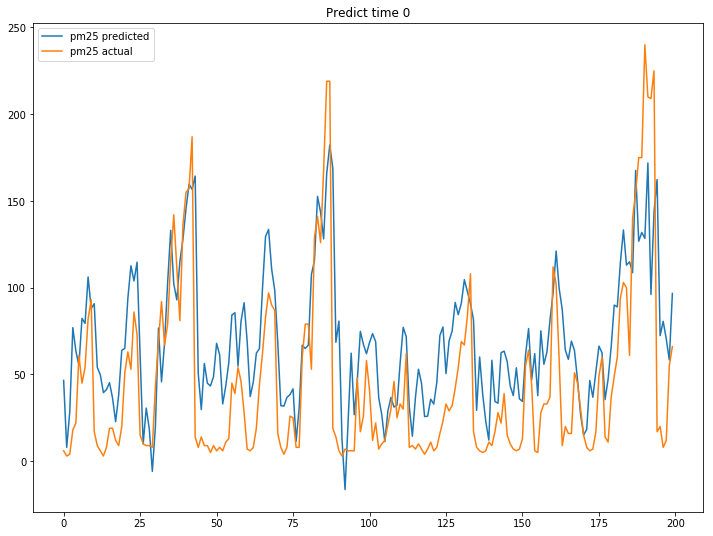

predict_hours 0
mae:
28.185610731470998
rmse:
41.28553151900299
mape:
0.6726840657676246


In [127]:
y_test_svm = clf.predict(test_X)

pm25_predict_svm = scaler.inverse_transform(np.tile(y_test_svm.reshape(-1, 1), 20))[:, -1]
pm25_actual = scaler.inverse_transform(np.tile(test_y.reshape(-1, 1), 20))[:, -1]

# Plot for SVM regression
for i in range(predict_hours):
    plt.subplot(predict_hours, 1, i+1)
    plt.plot(pm25_predict_svm[-200:], '-', label = 'pm25 predicted')
    plt.plot(pm25_actual[-200:], '-', label = 'pm25 actual')
    plt.legend()
    plt.title('Predict time '+ str(i))
    plt.show()

for i in range(predict_hours):
    print("predict_hours " + str(i))
    print("mae:")
    print(mean_absolute_error(pm25_predict_svm, pm25_actual))
    print("rmse:")
    print(math.sqrt(mean_squared_error(pm25_predict_svm, pm25_actual)))
    print("mape:")
    print(mean_absolute_percentage_error(pm25_predict_svm, pm25_actual))

## Preprocessing

In [21]:
# normalize data 数据归一化
train_data = pd.concat([best_feat, data['pm25(t)']], axis=1)
values = train_data.values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

train, test = train_test_split(scaled, test_size=0.2)
train_X = train[:, :19]
train_y = train[:,19]
test_X = test[:, :19]
test_y = test[:,19]

reg = linear_model.LinearRegression()
reg.fit(train_X, train_y)
y_predict1 = reg.predict(test_X)



## Training (Linear regression, Random Forest, SVR)

In [155]:
scaled.shape

(2660, 20)

In [158]:
print("Linear regression: {a:f}".format(a=np.mean(rmse_list1)))
print("Random Forest: {a:f}".format(a=np.mean(rmse_list2)))
print("SVR: {a:f}".format(a=np.mean(rmse_list3)))

Linear regression: 44.428244
Random Forest: 45.035786
SVR: 62.875748


In [186]:
# inverse transform
def inv_normalization(y):
    return scaler.inverse_transform(np.concatenate((test_X, y.reshape((len(y), 1))), axis=1))[:, -1]
    

In [170]:
test_y.shape

(532,)

In [207]:
rmse_list1 = []
rmse_list2 = []
rmse_list3 = []
for i in range(5):
    print(i)
    train, test = train_test_split(data.values, test_size=0.2)
    train_X = train[:, :21*8]
    train_y = train[:,21*8]
    test_X = test[:, :21*8]
    test_y = test[:,21*8]
    # linear regression
    reg = linear_model.LinearRegression()
    reg.fit(train_X, train_y)
    y_predict1 = reg.predict(test_X)
    
    # random forest
#     rforest = RandomForestRegressor(n_estimators = 300, random_state = 0) 
#     rforest.fit(train_X, train_y)
#     y_predict2 = rforest.predict(test_X)
    
    #SVR
    clf = svm.SVR(kernel='rbf', C=1e5, gamma=1e-6)
    clf.fit(train_X, train_y)
    y_predict3 = clf.predict(test_X)
    
    RMSE1 = math.sqrt(mean_squared_error(y_predict1, test_y))
#     RMSE2 = math.sqrt(mean_squared_error(y_predict2, test_y))
    RMSE3 = math.sqrt(mean_squared_error(y_predict3, test_y))
    
    rmse_list1.append(RMSE1)
#     rmse_list2.append(RMSE2)
    rmse_list3.append(RMSE3)

print("Linear regression: {a:f}".format(a=np.mean(rmse_list1)))
# print("Random Forest: {a:f}".format(a=np.mean(rmse_list2)))
print("SVR: {a:f}".format(a=np.mean(rmse_list3)))

0
1
2
3
4
Linear regression: 46.323526
SVR: 72.665301


In [22]:
data.values[:,21*8]

array([178., 119., 239., ...,  12.,  55.,  66.])

## LSTM

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

/Users/luoweimeng/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [23]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(predict_hours))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

IndexError: tuple index out of range

In [25]:
train_X.shape

(2128, 19)